In [3]:
from pathlib import Path
import torch
import torchvision.models as models
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from torch.utils.data import Dataset, DataLoader
import openslide
import cv2 as cv
import seaborn as sns
import scipy.ndimage as ndimage
from natsort import natsorted
import yaml
from easydict import EasyDict as edict


thispath = Path.cwd().resolve()

aoecdir = Path("/mnt/nas4/datasets/ToReadme/ExaMode_Dataset1/AOEC")

datadir = Path(thispath.parent / "data")

pyhistdir = Path(datadir / "Mask_PyHIST_v2")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Seed for reproducibility
seed = 33
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)


def yaml_load(fileName):
    dict_config = None
    with open(fileName, 'r') as ymlfile:
        dict_config = edict(yaml.safe_load(ymlfile))

    return dict_config


class ModelOption():
    def __init__(self, model_name: str,
                 num_classes: int,
                 freeze=False,
                 num_freezed_layers=0,
                 dropout=0.0, 
                 embedding_bool=False,
                 pool_algorithm=None
                 ):

        self.model_name = model_name
        self.num_classes = num_classes
        self.num_freezed_layers = num_freezed_layers
        self.dropout = dropout
        self.embedding_bool = embedding_bool
        self.pool_algorithm = pool_algorithm

        if self.model_name.lower() == "resnet50":
            """ ResNet50 """
            self.net = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

            self.input_features = self.net.fc.in_features  # 2048
            

            self.resize_param = 224

        elif self.model_name.lower() == "resnet34":
            """ ResNet34 """
            self.net = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

            self.input_features = self.net.fc.in_features  # 2048
            

            self.resize_param = 224

        elif self.model_name.lower() == "resnet101":
            """ ResNet101 """
            self.net = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

            self.input_features = self.net.fc.in_features  # 2048
            

            self.resize_param = 224

        elif self.model_name.lower() == "convnext":
            """ ConvNeXt small """
            self.net = models.convnext_small(weights='DEFAULT')


            self.input_features = self.net.classifier[2].in_features  # 768

            self.resize_param = 224

        elif self.model_name.lower() == "swin":
            """ Swin Transformer V2 -T """
            self.net = models.swin_v2_t(weights=models.Swin_V2_T_Weights.DEFAULT)

            self.input_features = self.net.head.in_features  # 768

            self.resize_param = 224

        elif self.model_name.lower() == "efficient":
            """ EfficientNet b0 """
            self.net = models.efficientnet_b0(weights='DEFAULT')

            self.input_features = self.net.classifier[1].in_features  # 1200

            self.resize_param = 224

        else:
            print("Invalid model name, MODEL NOT LOAD")
            TypeError("Valid model names are 'resnet', 'convnext', 'swim' or 'efficient'")
            exit()

    def set_parameter_requires_grad(model, number_frozen_layers, feature_layers=8):
        for k, child in enumerate(model.named_children()):
            if k == number_frozen_layers or k == feature_layers:
                break
            for param in child[1].parameters():
                param.requires_grad = False

        return model

class MIL_model(torch.nn.Module):
    def __init__(self, model, hidden_space_len, cfg):

        super(MIL_model, self).__init__()
		
        self.model = model
        self.fc_input_features = self.model.input_features
        self.num_classes = self.model.num_classes
        self.hidden_space_len = hidden_space_len
        self.net = self.model.net
        self.cfg = cfg

        self.conv_layers = torch.nn.Sequential(*list(self.net.children())[:-1])

        if (torch.cuda.device_count()>1):
            # 0 para GPU buena
            self.conv_layers = torch.nn.DataParallel(self.conv_layers, device_ids=[0])


        if self.model.embedding_bool:
            if ('resnet34' in self.model.model_name):
                self.E = self.hidden_space_len
                self.L = self.E
                self.D = self.hidden_space_len
                self.K = self.num_classes

            elif ('resnet101' in self.model.model_name):
                self.E = self.hidden_space_len
                self.L = self.E
                self.D = self.hidden_space_len
                self.K = self.num_classes

            elif ('convnext' in self.model.model_name):
                self.E = self.hidden_space_len
                self.L = self.E
                self.D = self.hidden_space_len
                self.K = self.num_classes

            self.embedding = torch.nn.Linear(in_features=self.fc_input_features, out_features=self.E)
            self.post_embedding = torch.nn.Linear(in_features=self.E, out_features=self.E)

        else:
            self.fc = torch.nn.Linear(in_features=self.fc_input_features, out_features=self.num_classes)

            if ('resnet34' in self.model.model_name):
                self.L = self.fc_input_features
                self.D = self.hidden_space_len
                self.K = self.num_classes   
            
            elif ('resnet101' in self.model.model_name):
                self.L = self.E
                self.D = self.hidden_space_len
                self.K = self.num_classes

            elif ('convnext' in self.model.model_name):
                self.L = self.E
                self.D = self.hidden_space_len
                self.K = self.num_classes
		
        if (self.model.pool_algorithm=="attention"):
            self.attention = torch.nn.Sequential(
                torch.nn.Linear(self.L, self.D),
                torch.nn.Tanh(),
                torch.nn.Linear(self.D, self.K)
            )
            
            if "NoChannel" in self.cfg.data_augmentation.featuresdir:
                print("== Attention No Channel ==")
                self.embedding_before_fc = torch.nn.Linear(self.E * self.K, self.E)

            elif "AChannel" in self.cfg.data_augmentation.featuresdir:
                print("== Attention with A Channel for multilabel ==")
                self.attention_channel = torch.nn.Sequential(torch.nn.Linear(self.L, self.D),
                                                    torch.nn.Tanh(),
                                                    torch.nn.Linear(self.D, 1))
                self.embedding_before_fc = torch.nn.Linear(self.E, self.E)

            

        self.embedding_fc = torch.nn.Linear(self.E, self.K)

        self.dropout = torch.nn.Dropout(p=self.model.dropout)
        # self.tanh = torch.nn.Tanh()
        self.relu = torch.nn.ReLU()

        self.LayerNorm = torch.nn.LayerNorm(self.E * self.K, eps=1e-5)
        # self.activation = self.tanh
        self.activation = self.relu 

    def forward(self, x, conv_layers_out):

        #if used attention pooling
        A = None
        #m = torch.nn.Softmax(dim=1)

        if x is not None:
            #print(x.shape)
            conv_layers_out=self.conv_layers(x)
            #print(x.shape)

            conv_layers_out = conv_layers_out.view(-1, self.fc_input_features)

        if self.model.embedding_bool:
            embedding_layer = self.embedding(conv_layers_out)
							
            #embedding_layer = self.LayerNorm(embedding_layer)
            features_to_return = embedding_layer
            embedding_layer = self.dropout(embedding_layer)

        else:
            embedding_layer = conv_layers_out
            features_to_return = embedding_layer


        A = self.attention(features_to_return)

        A = torch.transpose(A, 1, 0)

        A = F.softmax(A, dim=1)

        wsi_embedding = torch.mm(A, features_to_return)

        if "NoChannel" in self.cfg.data_augmentation.featuresdir:
            print("== Attention No Channel ==")
            wsi_embedding = wsi_embedding.view(-1, self.E * self.K)

            cls_img = self.embedding_before_fc(wsi_embedding)

        elif "AChannel" in self.cfg.data_augmentation.featuresdir:
            print("== Attention with A Channel for multilabel ==")
            attention_channel = self.attention_channel(wsi_embedding)

            attention_channel = torch.transpose(attention_channel, 1, 0)

            attention_channel = F.softmax(attention_channel, dim=1)

            cls_img = torch.mm(attention_channel, wsi_embedding)

            # cls_img = self.embedding_before_fc(cls_img)

        cls_img = self.activation(cls_img)

        features_image = cls_img

        cls_img = self.dropout(cls_img)

        Y_prob = self.embedding_fc(cls_img)

        Y_prob = torch.squeeze(Y_prob)

        return Y_prob, A

    
class Dataset_instance_MIL(Dataset):

    def __init__(self, wsi_path_patches, transform=None, preprocess=None):
        self.wsi_path_patches = wsi_path_patches
        self.transform = transform
        self.preprocess = preprocess

    def __len__(self):
        return len(self.wsi_path_patches)

    def __getitem__(self, index):
        # Select sample
        wsi_id = self.wsi_path_patches[index][0]
        # Load data and get label
        input_tensor = cv.imread(wsi_id)
        input_tensor = cv.cvtColor(input_tensor, cv.COLOR_BGR2RGB)
        #img.close()

        if self.transform:
            input_tensor = self.transform(image=input_tensor)['image']
            #X = pipeline_transform_local(image=X)['image']

        #data transformation
        if self.preprocess:
            input_tensor = self.preprocess(input_tensor).type(torch.FloatTensor)
        
        return input_tensor

In [4]:
experiment_name = "f_MIL_res34v2_v2_rumc_best_cosine_v3_fold_0"
downsample_factor = 4

# Discard 4, 5
#Best 2 Good 1 , 7 ~6 and 0

#v2
# Good
# 1 No, 2 No, 5, 9, 12 No, 13, 17 14(come si come sa)

# not that good
# 4 --> have anootations

# Best
# 0 --> have annotations 2 ---
# 5 --> is good ----
# 13 --> have annotations 2 ---
# ~ 9 --> 3 Normal tissue NO
# ~ 17 ---
# 3 come si come sa  ---
# 11 come si come sa NO
# 10 not bad can be used NO

# Bad (error loading image)
# 3, 6(bad results), 7 No, 10, 11, 15 No, 16

# 8?

select_wsi = [["000030530100324275", 2], ["000030614300329498", 0], ["000030737800334725", 0],
              ["000031119900354404", 1], ["000031206300360810", 1], ["000031206300360819", 1],
              ["000031796600388466", 2], ["000031796600390249", 2], ["000031991400401020", 3],
              ["000031991400401021", 3], ["000032434900422318", 1], ["000032696100434197", 0],
              ["000033124800454345", 0], ["000033783100517779", 2], ["000034131800547409", 2],
              ["000035206200645882", 3], ["000035206200645884", 3], ["000035858400714851", 2]]

patient = select_wsi[11]

svs_dir = natsorted([i for i in aoecdir.rglob("*.svs") if "LungAOEC" in str(i) and
                                                      (select_wsi[0][0] in str(i )
                                                       or select_wsi[1][0] in str(i)
                                                       or select_wsi[2][0] in str(i)
                                                       or select_wsi[3][0] in str(i)
                                                       or select_wsi[4][0] in str(i)
                                                       or select_wsi[5][0] in str(i)
                                                       or select_wsi[6][0] in str(i)
                                                       or select_wsi[7][0] in str(i)
                                                       or select_wsi[8][0] in str(i)
                                                       or select_wsi[9][0] in str(i)
                                                       or select_wsi[10][0] in str(i)
                                                       or select_wsi[11][0] in str(i)
                                                       or select_wsi[12][0] in str(i)
                                                       or select_wsi[13][0] in str(i)
                                                       or select_wsi[14][0] in str(i)
                                                       or select_wsi[15][0] in str(i)
                                                       or select_wsi[16][0] in str(i)
                                                       or select_wsi[17][0] in str(i)
                                                       )], key=str)
print(svs_dir)
class_lung = patient[1]
for dir in svs_dir:
      if patient[0] in str(dir):
            file_path = dir
filename = file_path.stem

print(filename)
print(file_path)
print(class_lung)


labels_auto = csv_dataset_AOEC = Path(datadir / "labels.csv") 
labels_manual = csv_dataset_AOEC = Path(datadir / "manual_labels.csv") 

modeldir = Path(thispath.parent / "trained_models" / "MIL" / experiment_name)

cfg = yaml_load(modeldir / f"config_{experiment_name}.yml")

bestdir = Path(modeldir / cfg.dataset.magnification / cfg.model.model_name)

checkpoint = torch.load(bestdir / f"{experiment_name}.pt")

train_loss = checkpoint["train_loss"]
valid_loss = checkpoint["valid_loss"]
epoch = checkpoint["epoch"] + 1

print(f"Loaded {experiment_name} using as backbone {cfg.model.model_name}, a Best "
            f"Loss in Train of {train_loss} and in Validation of {valid_loss} at Epoch "
            f"{epoch+1}.")

model = ModelOption(cfg.model.model_name,
                  cfg.model.num_classes,
                  freeze=cfg.model.freeze_weights,
                  num_freezed_layers=cfg.model.num_frozen_layers,
                  dropout=cfg.model.dropout,
                  embedding_bool=cfg.model.embedding_bool,
                  pool_algorithm=cfg.model.pool_algorithm
                  )

hidden_space_len = cfg.model.hidden_space_len

net = MIL_model(model, hidden_space_len, cfg)

net.load_state_dict(checkpoint["model_state_dict"], strict=False)
net.to(device)
net.eval()

preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=cfg.dataset.mean, std=cfg.dataset.stddev),
            transforms.Resize(size=(model.resize_param, model.resize_param),
            antialias=True)
      ])

# 1, 2, 5, 9, 12, 13, 17 14(come si come sa)

print(select_wsi[1][0])
print(select_wsi[2][0])
print(select_wsi[5][0])
print(select_wsi[9][0])
print(select_wsi[12][0])
print(select_wsi[13][0])
print(select_wsi[17][0])
print(select_wsi[14][0])

[PosixPath('/mnt/nas4/datasets/ToReadme/ExaMode_Dataset1/AOEC/LungAOEC_List1/000031119900354404.svs'), PosixPath('/mnt/nas4/datasets/ToReadme/ExaMode_Dataset1/AOEC/LungAOEC_List1/000031206300360810.svs'), PosixPath('/mnt/nas4/datasets/ToReadme/ExaMode_Dataset1/AOEC/LungAOEC_List1/000031206300360819.svs'), PosixPath('/mnt/nas4/datasets/ToReadme/ExaMode_Dataset1/AOEC/LungAOEC_List2/000030530100324275.svs'), PosixPath('/mnt/nas4/datasets/ToReadme/ExaMode_Dataset1/AOEC/LungAOEC_List2/000030614300329498.svs'), PosixPath('/mnt/nas4/datasets/ToReadme/ExaMode_Dataset1/AOEC/LungAOEC_List2/000030737800334725.svs'), PosixPath('/mnt/nas4/datasets/ToReadme/ExaMode_Dataset1/AOEC/LungAOEC_List2/000031796600388466.svs'), PosixPath('/mnt/nas4/datasets/ToReadme/ExaMode_Dataset1/AOEC/LungAOEC_List2/000031796600390249.svs'), PosixPath('/mnt/nas4/datasets/ToReadme/ExaMode_Dataset1/AOEC/LungAOEC_List2/000031991400401020.svs'), PosixPath('/mnt/nas4/datasets/ToReadme/ExaMode_Dataset1/AOEC/LungAOEC_List2/00003

In [5]:
def available_magnifications(mpp, level_downsamples):
    mpp = float(mpp)
    if (mpp<0.26):
        magnification = 40
    else:
        magnification = 20

    mags = []
    for l in level_downsamples:
        mags.append(magnification/l)

    return mags

file = openslide.open_slide(file_path)
mpp = file.properties['openslide.mpp-x']

level_downsamples = file.level_downsamples
mags = available_magnifications(mpp, level_downsamples)

new_patch_size = 224

file_pyhist = Path(pyhistdir / file_path.parent.stem / filename)

mask = cv.imread(str(file_pyhist / f"binary_{filename}.png"))
mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)

mask_np = cv.resize(mask, (int(mask.shape[1]/downsample_factor), int(mask.shape[0]/downsample_factor)))

thumb = file.get_thumbnail((mask_np.shape[1], mask_np.shape[0]))
thumb_np = np.asarray(thumb)

mask_empty = np.zeros((mask_np.shape[0], mask_np.shape[1]))

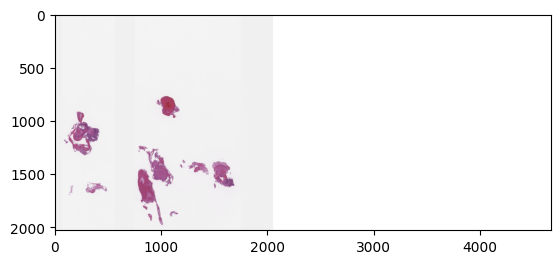

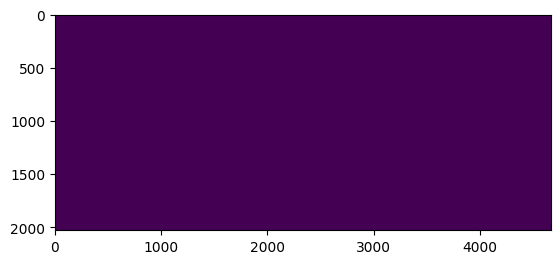

In [6]:
plt.imshow(thumb_np)
plt.show()
plt.imshow(mask_empty)
plt.show()

In [7]:
metadata_preds = pd.read_csv(file_pyhist / f"{filename}_densely_filtered_metadata_v2.csv")


patches = pd.read_csv(file_pyhist / f"{filename}_densely_filtered_paths_v2.csv").values

names = metadata_preds["patch_name"]
coords_x = metadata_preds["row"].values
coords_y = metadata_preds["column"].values

n_elems = len(patches)

    #params generator instances
batch_size_instance = 1

num_workers = 2
params_instance = {'batch_size': batch_size_instance,
        #'shuffle': True,
        'num_workers': num_workers}

instances = Dataset_instance_MIL(patches, preprocess=preprocess)
validation_generator_instance = DataLoader(instances, **params_instance)


In [8]:
dicts = []
features = [] 
print(mags)
with torch.no_grad():
    for i, patch in enumerate(validation_generator_instance):
        patch = patch.to(device, non_blocking=True)
        
        if mags[0] == 40.0:
          coord_x = (coords_x[i]*256)/(4 * downsample_factor/2)
          coord_y = (coords_y[i]*256)/(4 * downsample_factor/2)
        elif mags[0] == 20.0:
          coord_x = (coords_x[i]*256)/(8 * downsample_factor/2)
          coord_y = (coords_y[i]*256)/(8 * downsample_factor/2)
           

        # forward + backward + optimize
        feats = net.conv_layers(patch)
        feats = feats.view(-1, net.fc_input_features)
        feats_np = feats.cpu().data.numpy()

        features.extend(feats_np)
        
        
        d = {
          "ID": names[i],
          "coord_x": int(coord_x),
          "coord_y": int(coord_y),
          "prob":None  
        }
        dicts.append(d)

features_np = np.reshape(features,(n_elems, net.fc_input_features))
#torch.cuda.empty_cache()

net.zero_grad()

inputs = torch.tensor(features_np).float().to(device,non_blocking=True)

pred_wsi, attention_weights = net(None, inputs)

#attention_weights = torch.transpose(attention_weights, 1, 0)

pred_wsi = pred_wsi.cpu().data.numpy()
print(pred_wsi)

attentions_np = attention_weights.cpu().data.numpy()

[40.0, 9.999769051339886, 2.4997983468173164, 0.6246851030353855]
== Attention No Channel ==
[ 1.0557199 -2.0324173 -2.383232  -2.0499318]


In [9]:
print(attentions_np)
print(attentions_np.shape)

[[2.86636670e-04 2.48222670e-04 4.20950731e-04 ... 9.08470422e-04
  5.22212824e-03 1.76208699e-03]
 [1.47499613e-05 6.80090216e-06 9.82896563e-06 ... 8.54655264e-06
  1.51353495e-04 1.28737602e-05]
 [1.68234747e-05 1.19320657e-05 1.28523934e-05 ... 1.00361995e-05
  1.01001322e-04 7.67611073e-06]
 [5.18799534e-05 4.45880796e-05 4.01361031e-05 ... 8.32754438e-07
  2.24774249e-06 7.66838696e-07]]
(4, 395)


In [10]:
my_cmap_red = sns.color_palette("Reds", 255, as_cmap=True)
my_cmap_green = sns.color_palette("Greens", 255, as_cmap=True)
my_cmap_yellow = sns.color_palette("YlOrBr", 255, as_cmap=True)
my_cmap_blue = sns.color_palette("Blues", 255, as_cmap=True)
my_cmap_black = sns.color_palette("coolwarm", 255, as_cmap=True)

outputir = Path(datadir / "Attention_maps")
Path(outputir).mkdir(exist_ok=True, parents=True)
    
    #filename_save_mask = '/home/niccolo/ExamodePipeline/Multiple_Instance_Learning/Colon/images/heat_map_'+wsi+'_binary_ss_'+MAGNIFICATION+'.png'        

if (class_lung==0):
    type_tissue = 'sclc'
    my_cmap = my_cmap_red
elif (class_lung==1):
    type_tissue = 'luad'
    my_cmap = my_cmap_green
elif (class_lung==2):
    type_tissue = 'lusc'
    my_cmap = my_cmap_yellow
elif (class_lung==3):
    type_tissue = 'normal'
    my_cmap = my_cmap_blue
    


for i in range(attentions_np.shape[1]):
    #dicts[i]["prob"]=(outputs_np[i][class_colon]*attention_weights[i][class_colon])
    dicts[i]["prob"] = attentions_np[class_lung, i]

    #filename_save_mask = '/home/niccolo/ExamodePipeline/Multiple_Instance_Learning/Colon/images/heat_map_'+wsi+'_'+type_tissue+'_ss_'+MAGNIFICATION+'.png'        

    
torch.cuda.empty_cache()

In [11]:
pixel_size = int(256/(10.0))

for d in dicts:
    x_cord_m = d['coord_x']
    y_cord_m = d['coord_y']
    
    x_cord_f = x_cord_m+pixel_size
    y_cord_f = y_cord_m+pixel_size
    for x in range(x_cord_m, x_cord_f):
        for y in range(y_cord_m, y_cord_f):
            mask_empty[x,y]=d['prob']

print(dicts)

[{'ID': '000032696100434197_3478', 'coord_x': 736, 'coord_y': 3840, 'prob': 0.00028663667}, {'ID': '000032696100434197_3479', 'coord_x': 736, 'coord_y': 3872, 'prob': 0.00024822267}, {'ID': '000032696100434197_3480', 'coord_x': 736, 'coord_y': 3904, 'prob': 0.00042095073}, {'ID': '000032696100434197_3536', 'coord_x': 768, 'coord_y': 1024, 'prob': 0.00023394293}, {'ID': '000032696100434197_3537', 'coord_x': 768, 'coord_y': 1056, 'prob': 0.0003154393}, {'ID': '000032696100434197_3623', 'coord_x': 768, 'coord_y': 3808, 'prob': 0.0009418195}, {'ID': '000032696100434197_3624', 'coord_x': 768, 'coord_y': 3840, 'prob': 8.0086116e-05}, {'ID': '000032696100434197_3625', 'coord_x': 768, 'coord_y': 3872, 'prob': 0.000185468}, {'ID': '000032696100434197_3626', 'coord_x': 768, 'coord_y': 3904, 'prob': 0.0001170757}, {'ID': '000032696100434197_3627', 'coord_x': 768, 'coord_y': 3936, 'prob': 0.00063371734}, {'ID': '000032696100434197_3681', 'coord_x': 800, 'coord_y': 992, 'prob': 0.0003108938}, {'ID'

In [12]:
def smooth_heatmap(heatmap, sigma):
    
    heatmap_smooth = ndimage.gaussian_filter(heatmap, sigma=sigma, order=0)
    
    return np.array(heatmap_smooth)

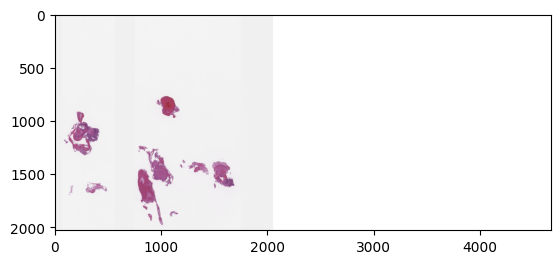

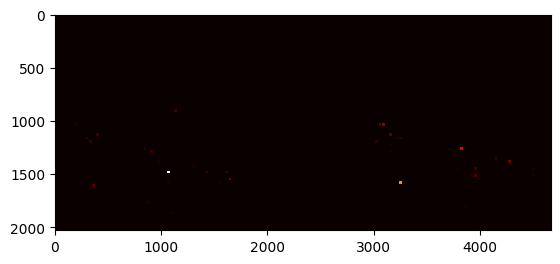

In [13]:
fig, ax = plt.subplots()

mask_copy = mask_empty

heatmap_np = np.uint8(mask_copy*255)
plt.imshow(thumb)
plt.show()
plt.imshow(heatmap_np, cmap='hot', interpolation='nearest')
plt.show()

36
(2029, 4668)


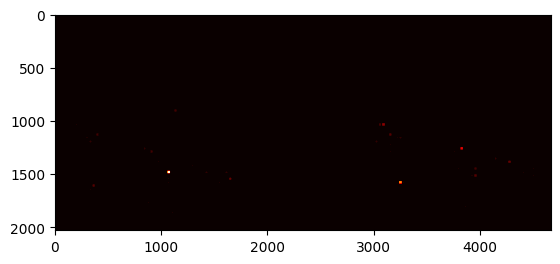

In [14]:
sigma = 2
heatmap_smooth_np = smooth_heatmap(heatmap_np, sigma)
print(np.max(heatmap_smooth_np))
print(heatmap_smooth_np.shape)
heatmap_smooth_np[heatmap_smooth_np < 0.000002] = 0
plt.imshow(heatmap_smooth_np, cmap='hot', interpolation='nearest')
plt.show()

(2029, 4667, 3)


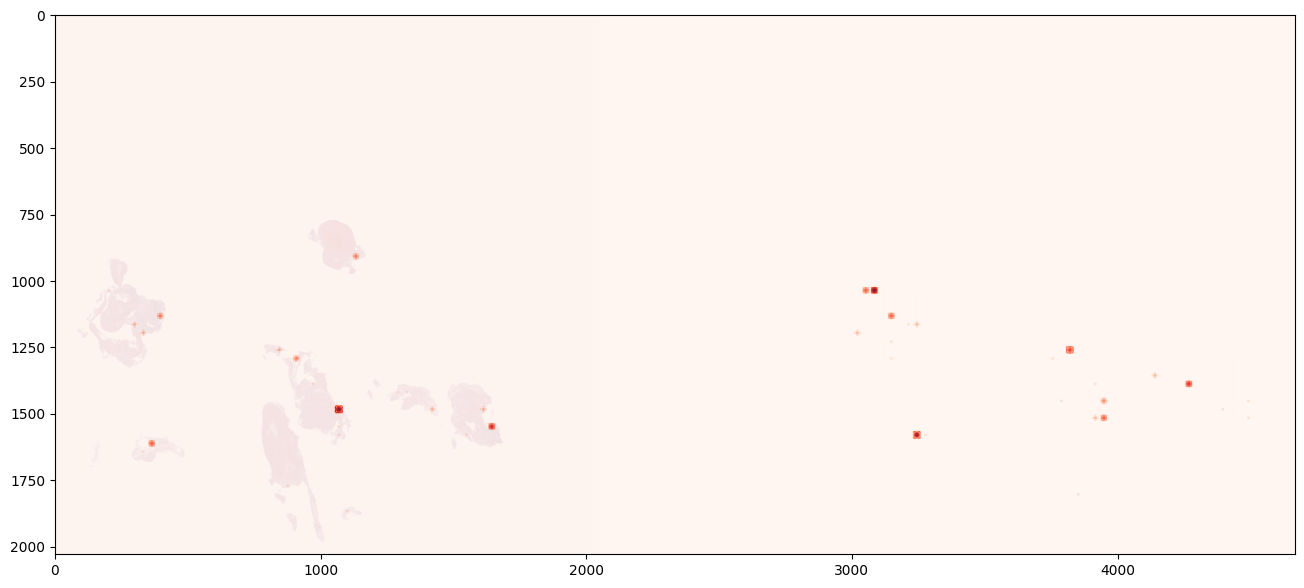

In [15]:
import pylab
Fi = pylab.gcf()
DefaultSize = Fi.get_size_inches()

print(thumb_np.shape)

thumb_x = int(thumb_np.shape[1]/2)

fig = plt.gcf()
DPI = fig.get_dpi()
fig.set_size_inches(1600.0/float(DPI),1200.0/float(DPI))

plt.clf()
plt.imshow(thumb)
plt.imshow(35*heatmap_smooth_np, alpha=0.9, cmap=my_cmap)